In [ ]:
from google.colab import files
files.upload()

Saving dataset.zip to dataset.zip


KeyboardInterrupt: ignored

In [ ]:
import os
import zipfile
import random
from shutil import copyfile
local_zipfile = '/content/dataset.zip'
zip_ref = zipfile.ZipFile(local_zipfile,'r');
zip_ref.extractall('/tmp')
zip_ref.close()

In [ ]:
print(len(os.listdir('/tmp/dataset/images/0')))
print(len(os.listdir('/tmp/dataset/images/1')))

269
183


In [ ]:
!rm -rf '/tmp/pavbhaji-not_pavbhaji'

In [ ]:
##Create a directory for Pavbhaji-NotPavbhaji
##And subdirectories for training and testing
try:
  os.mkdir('/tmp/pavbhaji-not_pavbhaji')
  os.mkdir('/tmp/pavbhaji-not_pavbhaji/training')
  os.mkdir('/tmp/pavbhaji-not_pavbhaji/testing')
  os.mkdir('/tmp/pavbhaji-not_pavbhaji/training/pavbhaji')
  os.mkdir('/tmp/pavbhaji-not_pavbhaji/training/not_pavbhaji')
  os.mkdir('/tmp/pavbhaji-not_pavbhaji/testing/pavbhaji')
  os.mkdir('/tmp/pavbhaji-not_pavbhaji/testing/not_pavbhaji')
except OSError:
  pass

In [ ]:
def train_test_split(source, training, testing, split_size):
  files = []
  
  for file in os.listdir(source):
    filepath = source + file
    if (os.path.getsize(filepath)>0):
      files.append(file)
    else:
      print('Ignoring the file: ' + str(filename) + ' as it is zero size.')
    
  training_size = int(len(files)*split_size)
  testing_size = len(files) - training_size
  shuffled_set = random.sample(files, len(files))
  training_dataset = files[:training_size]
  testing_dataset = files[-testing_size:]

  for filename in training_dataset:
    current_file = source + filename
    destination_path = training + filename
    copyfile(current_file, destination_path)
    
  for filename in testing_dataset:
    current_file = source + filename
    destination_path = testing + filename 
    copyfile(current_file, destination_path)

In [ ]:
esting

In [ ]:
###Spliting the data for pavbhaaji images
split_size = 0.8
train_test_split(pavbhaji_source,training_source_pavbhaji,testing_source_pavbhaji, split_size)

In [ ]:
train_test_split(notpavbhaji_source,training_source_notpavbhaji,testing_source_notpavbhaji, split_size)

In [ ]:
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
##Add the data-augmentation parameters to ImageDataGenerator
train_dir = '/tmp/pavbhaji-not_pavbhaji/training'
train_datagen = ImageDataGenerator(rescale=1.0/255, rotation_range = 40, width_shift_range = 0.2,
                                   height_shift_range = 0.2, zoom_range = 0.2, shear_range = 0.2,
                                   vertical_flip=True,horizontal_flip = True, fill_mode = 'nearest')
train_generator = train_datagen.flow_from_directory(train_dir, batch_size = 64, 
                                                    target_size=(224,224), class_mode = 'categorical',
                                                    color_mode ='rgb',shuffle = True)
validation_dir = '/tmp/pavbhaji-not_pavbhaji/testing'
validation_datagen = ImageDataGenerator(rescale = 1./255)
validation_generator = validation_datagen.flow_from_directory(validation_dir,batch_size=8,
                                                              target_size=(224,224),class_mode = 'categorical',
                                                              color_mode ='rgb',shuffle = False)


Found 361 images belonging to 2 classes.
Found 91 images belonging to 2 classes.


In [ ]:
labels = '\n'.join(sorted(train_generator.class_indices.keys()))
with open('labels.txt', 'w') as f:
  f.write(labels)
labels = dict((v,k) for k,v in train_generator.class_indices.items())
print(labels)

{0: 'not_pavbhaji', 1: 'pavbhaji'}


In [ ]:
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
from tensorflow.keras.applications import InceptionV3,ResNet50V2
inception = InceptionV3(weights = 'imagenet',include_top = False, input_shape = (224,224,3))
resinet = ResNet50V2(weights='imagenet', input_shape = (224,224,3), include_top= False)

In [ ]:
for layer in inception.layers[:-50]:
    layer.trainable = False

for layer in resinet.layers[:-36]:
  layer.trainablec= False

In [ ]:
strategy = tf.distribute.get_strategy()

with strategy.scope():
    
# Create the model
    model = tf.keras.models.Sequential([#resinet,
                        inception,
                        tf.keras.layers.Conv2D(128,3,activation='relu'),
                        tf.keras.layers.Dropout(0.2),
                        tf.keras.layers.GlobalAveragePooling2D(),
                        tf.keras.layers.Flatten(),
                        tf.keras.layers.Dense(512,activation='relu'),
                        tf.keras.layers.Dense(256,activation='relu'),
                        tf.keras.layers.Dense(128,activation='relu'),
                        #tf.keras.layers.Dense(512,activation='relu'),
                        tf.keras.layers.Dense(2,activation='softmax')])

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='Adam',metrics=['accuracy'])

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import time
early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=15)
model_checkpoint = ModelCheckpoint('best-model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True) 

steps_per_epoch = train_generator.samples//train_generator.batch_size
validation_steps = validation_generator.samples//validation_generator.batch_size
start = time.time()
history = model.fit_generator(
    train_generator, steps_per_epoch=steps_per_epoch,epochs=50,
    validation_data=validation_generator, validation_steps=validation_steps,verbose=1,
    workers=4, callbacks=[early_stopping, model_checkpoint])
end = time.time()
print('Execution time: ', end-start)


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
5/5 [==============================] - 70s 12s/step - loss: 0.3076 - accuracy: 0.8093 - val_loss: 20.9714 - val_accuracy: 0.3864

Epoch 00001: val_accuracy improved from -inf to 0.38636, saving model to inception.h5
Epoch 2/50
5/5 [==============================] - 61s 10s/step - loss: 3.8100 - accuracy: 0.6953 - val_loss: 13.8572 - val_accuracy: 0.7727

Epoch 00002: val_accuracy improved from 0.38636 to 0.77273, saving model to inception.h5
Epoch 3/50
5/5 [==============================] - 61s 10s/step - loss: 0.1400 - accuracy: 0.9648 - val_loss: 34.2797 - val_accuracy: 0.7045

Epoch 00003: val_accuracy did not improve from 0.77273
Epoch 4/50
5/5 [==============================] - 64s 11s/step - loss: 0.3217 - accuracy: 0.9022 - val_loss: 65.9363 - val_accuracy: 0.6477

Epoch 00004: val_accuracy did not improve from 0.77273
Epoch 5/50
5/5 [==============================] - 61s 10s/step - loss: 0.3529 - accuracy: 0.9396 - val_loss: 35.6026 - val_accuracy: 0.6932

Epoch 0000

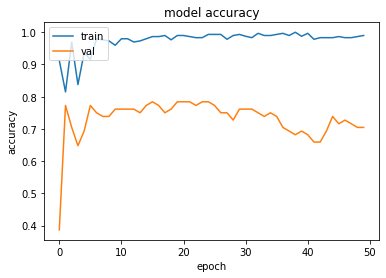

In [ ]:
# summarize history for accuracy
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'] )
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


In [ ]:
import numpy as np
from google.colab import files
from keras.preprocessing import image
uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = '/content/' + fn
  img = image.load_img(path, target_size=(224,224))
  img = image.img_to_array(img, dtype=np.uint8)
  img = np.array(img)/255.
  ##Loading the trained model
  model = tf.keras.models.load_model("inception.h5")
  plt.axis('off')
  plt.imshow(img.squeeze())
  p = model.predict(img[np.newaxis, ...])
  classes=[]
  prob=[]
  print("\nPROBABILITY OF Image\n")
  for i,j in enumerate (p[0],0):
    print(labels[i].upper(),':',round(j*100,2),'%')
    classes.append(labels[i])
    prob.append(round(j*100,2))